## Curate epithelium patches from BReAst Carcinoma Subtyping (BRACS) database (https://www.bracs.icar.cnr.it/) 

In [24]:
import os
import pandas as pd
import numpy as np
import openslide
import matplotlib.pyplot as plt
import glob
import cv2
from pathlib import Path
from PIL import Image
import random
import staintools

def extract_patch_ids_per_ROI(image_pt=None, patch_size=1024, center_region_size=256, max_total_attempts=30):
    existing_patch_ids = set()
    patch_infos = []
    total_attempts = 0
    
    roi_image = Image.open(image_pt)
    roi_id = os.path.basename(image_pt).split('.png')[0]
    source = roi_id.split("_")[-2]

    roi_array = np.array(roi_image)
    h, w = roi_array.shape[:2]
    
    # Check if ROI is large enough
    if w < patch_size or h < patch_size:
        print(f"ROI too small ({w}x{h}) for extracting {patch_size}x{patch_size} patch")
        return pd.DataFrame()
    
    center_x, center_y = w // 2, h // 2
    
    # Use center_region_size parameter
    half_center = center_region_size // 2
    center_left = max(patch_size // 2, center_x - half_center)
    center_right = min(w - patch_size // 2, center_x + half_center)
    center_top = max(patch_size // 2, center_y - half_center)
    center_bottom = min(h - patch_size // 2, center_y + half_center)
    
    if center_left >= center_right:
        center_left = patch_size // 2
        center_right = w - patch_size // 2
    
    if center_top >= center_bottom:
        center_top = patch_size // 2
        center_bottom = h - patch_size // 2
    
    if center_left >= center_right or center_top >= center_bottom:
        print(f"⚠️ ROI {roi_id} cannot safely sample from center region, skipping")
        return pd.DataFrame()
    
    print(f"ROI: {roi_id}, dimensions: {w}x{h}")
    print(f"Sampling area: ({center_left}-{center_right}, {center_top}-{center_bottom})")
    print(f"Sampling range: {center_right-center_left}x{center_bottom-center_top}")
    
    while total_attempts < max_total_attempts:
        rand_center_x = random.randint(center_left, center_right - 1)
        rand_center_y = random.randint(center_top, center_bottom - 1)
        
        half_patch = patch_size // 2
        patch_left = rand_center_x - half_patch
        patch_top = rand_center_y - half_patch
        
        patch_id = f"{roi_id}_{patch_left}_{patch_top}_{patch_size}"
        
        if patch_id not in existing_patch_ids:
            existing_patch_ids.add(patch_id)
            patch_info = {
                'patch_id': patch_id,
                'roi_id': roi_id,
                'source': source,
                'x': patch_left,
                'y': patch_top,
                'size': patch_size,
                'center_x': rand_center_x,
                'center_y': rand_center_y
            }
            patch_infos.append(patch_info)
        
        total_attempts += 1

    return pd.DataFrame(patch_infos)

In [25]:
basefolder="/scratch/prj/cb_microbiome/recovered/Siyuan/prj_NBTClassifier/npj_revision"
image_folder = '/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/BRACS_ROI'
os.listdir(image_folder+'/train')

['2_UDH', '3_FEA', '4_ADH', '1_PB', '0_N', '6_IC', '5_DCIS']

In [26]:
image_pts = glob.glob(f"{image_folder}/*/*/*.png")
print(len(image_pts))
image_pts[-6:]

4539


['/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/BRACS_ROI/test/5_DCIS/BRACS_292_DCIS_23.png',
 '/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/BRACS_ROI/test/5_DCIS/BRACS_292_DCIS_21.png',
 '/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/BRACS_ROI/test/5_DCIS/BRACS_1602_DCIS_3.png',
 '/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/BRACS_ROI/test/5_DCIS/BRACS_286_DCIS_6.png',
 '/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/BRACS_ROI/test/5_DCIS/BRACS_292_DCIS_10.png',
 '/scratch/prj/cb_normalbreast/prj_BreastAgeNet/WSIs/BRACS_ROI/test/5_DCIS/BRACS_1872_DCIS_4.png']

In [ ]:
patch_ids_df = []
failed_rois = []
for i, image_pt in enumerate(image_pts):
    print(f"Processing {i+1}/{len(image_pts)} ROI: {os.path.basename(image_pt)}")
    try:
        dfi = extract_patch_ids_per_ROI(
            image_pt=image_pt, 
            patch_size=1024, 
            center_region_size=256, 
            max_total_attempts=30
        )
        if not dfi.empty:
            patch_ids_df.append(dfi)
        else:
            failed_rois.append(os.path.basename(image_pt))
    except Exception as e:
        print(f"Error processing {os.path.basename(image_pt)}: {e}")
        failed_rois.append(os.path.basename(image_pt))
        continue

if patch_ids_df:
    final_patch_ids_df = pd.concat(patch_ids_df, ignore_index=True)
    print(f"Successfully processed: {len(final_patch_ids_df)} patches from {len(patch_ids_df)} ROIs")
else:
    final_patch_ids_df = pd.DataFrame()
    print("No patch information obtained")

if failed_rois:
    print(f"Failed ROIs ({len(failed_rois)}): {failed_rois}")

In [124]:
final_patch_ids_df.to_csv(f"{basefolder}/BRACS_patch_ids_CenterSampling.csv", index=False)
final_patch_ids_df

,patch_id,roi_id,source,x,y,size,center_x,center_y
0,BRACS_1811_UDH_28_305_169_1024,BRACS_1811_UDH_28,UDH,305,169,1024,817,681
1,BRACS_1811_UDH_28_346_87_1024,BRACS_1811_UDH_28,UDH,346,87,1024,858,599
2,BRACS_1811_UDH_28_332_74_1024,BRACS_1811_UDH_28,UDH,332,74,1024,844,586
3,BRACS_1811_UDH_28_205_74_1024,BRACS_1811_UDH_28,UDH,205,74,1024,717,586
4,BRACS_1811_UDH_28_230_20_1024,BRACS_1811_UDH_28,UDH,230,20,1024,742,532
...,...,...,...,...,...,...,...,...
91551,BRACS_1872_DCIS_4_327_934_1024,BRACS_1872_DCIS_4,DCIS,327,934,1024,839,1446
91552,BRACS_1872_DCIS_4_178_898_1024,BRACS_1872_DCIS_4,DCIS,178,898,1024,690,1410
91553,BRACS_1872_DCIS_4_376_893_1024,BRACS_1872_DCIS_4,DCIS,376,893,1024,888,1405
91554,BRACS_1872_DCIS_4_237_828_1024,BRACS_1872_DCIS_4,DCIS,237,828,1024,749,1340


In [125]:
print(np.unique(final_patch_ids_df['source'], return_counts=True))

(array(['ADH', 'DCIS', 'FEA', 'IC', 'N', 'PB', 'UDH'], dtype=object), array([ 8363, 18863,  8056, 17514, 10581, 19851,  8328]))


In [126]:
# sample 8000 per class
sampled_df = (
    final_patch_ids_df.groupby("source", group_keys=False)
    .apply(lambda x: x.sample(n=8000, random_state=42) if len(x) >= 8000 else x)
)
print(np.unique(sampled_df['source'], return_counts=True))

sampled_df.to_csv(f"{basefolder}/BRACS_patch_ids_CenterSampling_sampled8000.csv", index=False)

/tmp/ipykernel_2594662/630810643.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_patch_ids_df.groupby("source", group_keys=False)


(array(['ADH', 'DCIS', 'FEA', 'IC', 'N', 'PB', 'UDH'], dtype=object), array([8000, 8000, 8000, 8000, 8000, 8000, 8000]))


In [127]:
sampled_df

,patch_id,roi_id,source,x,y,size,center_x,center_y
16869,BRACS_1933_ADH_15_480_1126_1024,BRACS_1933_ADH_15,ADH,480,1126,1024,992,1638
77401,BRACS_1607_ADH_7_5_327_1024,BRACS_1607_ADH_7,ADH,5,327,1024,517,839
84703,BRACS_1580_ADH_14_31_636_1024,BRACS_1580_ADH_14,ADH,31,636,1024,543,1148
19100,BRACS_1934_ADH_9_4_80_1024,BRACS_1934_ADH_9,ADH,4,80,1024,516,592
77452,BRACS_1395_ADH_3_104_180_1024,BRACS_1395_ADH_3,ADH,104,180,1024,616,692
...,...,...,...,...,...,...,...,...
82217,BRACS_1944_UDH_1_354_363_1024,BRACS_1944_UDH_1,UDH,354,363,1024,866,875
75836,BRACS_265_UDH_19_1630_1157_1024,BRACS_265_UDH_19,UDH,1630,1157,1024,2142,1669
82971,BRACS_1503_UDH_14_745_177_1024,BRACS_1503_UDH_14,UDH,745,177,1024,1257,689
4893,BRACS_1810_UDH_7_12_468_1024,BRACS_1810_UDH_7,UDH,12,468,1024,524,980


## Feature extraction by the 1024px-based NBT-Classifier: see BRACS_TC1024.py

## Feature extraction by histoROI: see BRACS_histoROI.py

## Comparative Analysis of Epithelial Probabilities across Breast Tissue Categories: histoROI versus TC1024

### distribution and Wilcoxon rank-sum test

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import matplotlib as mpl
import os
import numpy as np
import openslide
from scipy.stats import gaussian_kde
from scipy.integrate import quad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['pdf.fonttype'] = 42  # TrueType 字体，可在 Illustrator 编辑
mpl.rcParams['ps.fonttype'] = 42

In [49]:
# 1024px-based NBT-Classifier

basefolder="/scratch/prj/cb_microbiome/recovered/Siyuan/prj_NBTClassifier/npj_revision"
df1 = pd.read_csv(f"{basefolder}/BRACS_patch_ids_overlap25_sampled3000_TC1024_batch0.csv")
df2 = pd.read_csv(f"{basefolder}/BRACS_patch_ids_overlap25_sampled3000_TC1024_batch1.csv")

TC1024_df = pd.concat([df1, df2], ignore_index=True)
print(len(TC1024_df))

epi_TC1024_df = TC1024_df[TC1024_df['cls'] == 'epithelium']
print(len(epi_TC1024_df))

print(f"{(len(epi_TC1024_df) / len(TC1024_df)) * 100:.2f}%")

56000
53836
96.14%


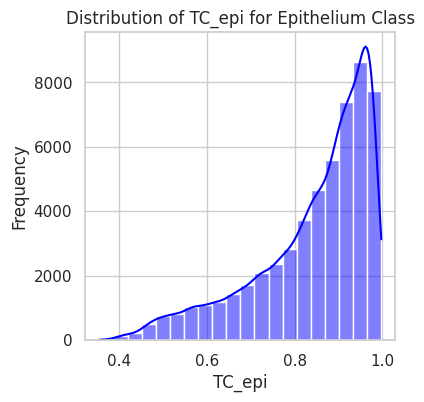

In [50]:
plt.figure(figsize=(4, 4))
sns.histplot(epi_TC1024_df['TC_epi'], bins=20, kde=True, color='blue')
plt.title('Distribution of TC_epi for Epithelium Class')
plt.xlabel('TC_epi')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [136]:
# Perform statistical tests (N vs. other categories)
p_values = {}
categories = []
raw_p_values = []

for category in order[1:]:  # Skip the first one 'N'
    data_N = epi_TC1024_df[epi_TC1024_df['source'] == 'N']['TC_epi'].apply(lambda x: -np.log10(1 - x))
    data_category = epi_TC1024_df[epi_TC1024_df['source'] == category]['TC_epi'].apply(lambda x: -np.log10(1 - x))
    
    # Perform Mann-Whitney U test (Non-parametric test)
    stat, p_value = mannwhitneyu(data_N, data_category)
    p_values[category] = p_value
    categories.append(category)
    raw_p_values.append(p_value)

# Apply FDR correction (Benjamini-Hochberg)
rejected, fdr_corrected_pvals, _, _ = multipletests(raw_p_values, alpha=0.05, method='fdr_bh')

# Print results with FDR correction
# Print results with FDR correction
print("Mann-Whitney U test results with FDR correction:")
print("=" * 60)
for i, category in enumerate(categories):
    # 简洁的显著性标记
    significance = "***" if fdr_corrected_pvals[i] < 0.001 else "**" if fdr_corrected_pvals[i] < 0.01 else "*" if fdr_corrected_pvals[i] < 0.05 else "ns"
    
    print(f"N vs {category:4}: p-value = {raw_p_values[i]:.4f}, FDR-corrected = {fdr_corrected_pvals[i]:.4f} {significance}")

print("\nSignificance codes: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")

Mann-Whitney U test results with FDR correction:
N vs PB  : p-value = 0.0000, FDR-corrected = 0.0000 ***
N vs UDH : p-value = 0.0000, FDR-corrected = 0.0000 ***
N vs FEA : p-value = 0.0000, FDR-corrected = 0.0000 ***
N vs ADH : p-value = 0.0000, FDR-corrected = 0.0000 ***
N vs DCIS: p-value = 0.0000, FDR-corrected = 0.0000 ***
N vs IC  : p-value = 0.0000, FDR-corrected = 0.0000 ***

Significance codes: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant


/tmp/ipykernel_2523612/2544591578.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TC_epi', y='source', data=epi_TC1024_df,


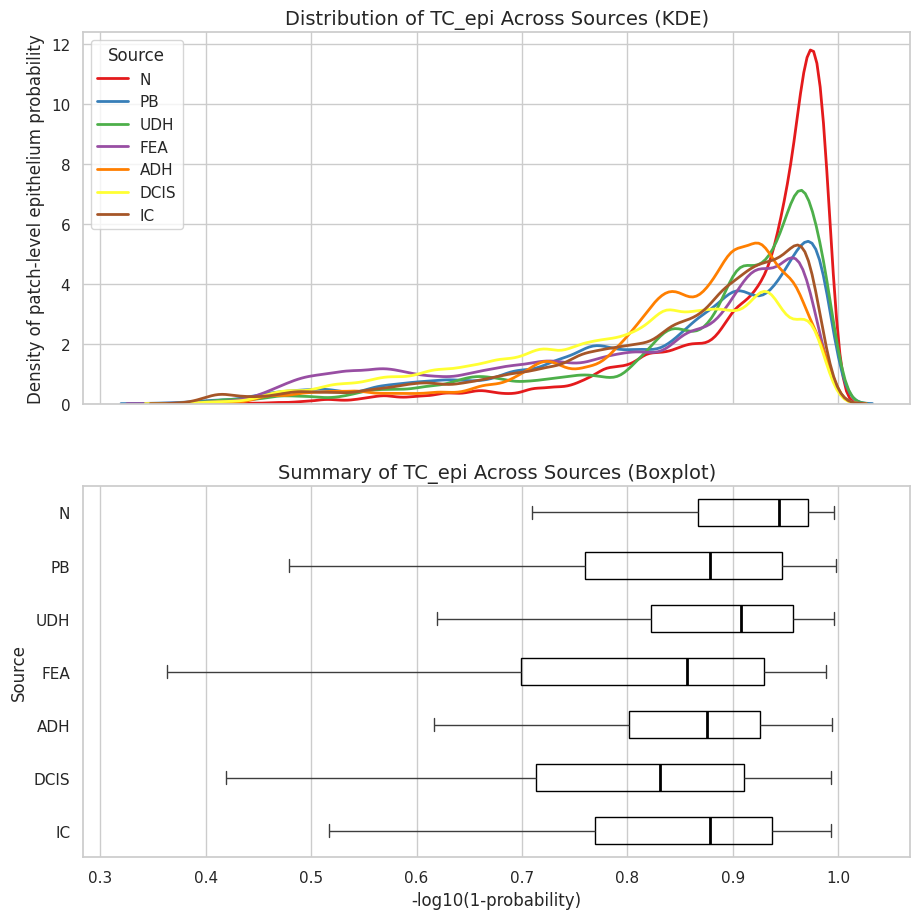

In [95]:
color_map0 = sns.color_palette('Set1', n_colors=len(source_order))
color_map = {source_order[i]: color_map0[i] for i in range(len(source_order))}

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Top subplot: KDE plot
for source in source_order:
    subset = epi_TC1024_df[epi_TC1024_df['source'] == source]['TC_epi']
    
    kde = sns.kdeplot(subset, bw_adjust=0.5, color=color_map[source], linewidth=2, label=source, ax=ax1)
    line = kde.get_lines()[-1]  # Current last line
    x_data = line.get_xdata()
    y_data = line.get_ydata()

ax1.set_ylabel('Density of patch-level epithelium probability', fontsize=12)
ax1.set_title('Distribution of TC_epi Across Sources (KDE)', fontsize=14)
ax1.legend(title='Source')

# Bottom subplot: Boxplot with color palette
sns.boxplot(x='TC_epi', y='source', data=epi_TC1024_df,
            order=source_order,
            whis=1.5, width=0.5, showcaps=True,
            boxprops={'facecolor':'none', 'edgecolor':'black'},
            medianprops={'color':'black', 'linewidth':2},
            showfliers=False, orient='h', ax=ax2,
            palette=color_map)  # Apply color map using palette

ax2.set_title('Summary of TC_epi Across Sources (Boxplot)', fontsize=14)
ax2.set_ylabel('Source', fontsize=12)
ax2.set_xlabel('-log10(1-probability)', fontsize=12)

plt.tight_layout(pad=3.0)
plt.savefig(f"{basefolder}/BRACS_patch_ids_CenterSampling_sampled8000_TC1024_epithelium_density_boxplot.pdf",
            dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [72]:
# HistoROI

basefolder="/scratch/prj/cb_microbiome/recovered/Siyuan/prj_NBTClassifier/npj_revision"
df1 = pd.read_csv(f"{basefolder}/BRACS_patch_ids_overlap25_sampled3000_histoROI_batch0.csv")
df2 = pd.read_csv(f"{basefolder}/BRACS_patch_ids_overlap25_sampled3000_histoROI_batch1.csv")
df3 = pd.read_csv(f"{basefolder}/BRACS_patch_ids_overlap25_sampled3000_histoROI_batch2.csv")
df4 = pd.read_csv(f"{basefolder}/BRACS_patch_ids_overlap25_sampled3000_histoROI_batch3.csv")

histoROI_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
print(len(histoROI_df))

epi_histoROI_df = histoROI_df[histoROI_df['cls'] == 'Epithelial']
print(len(epi_histoROI_df))

print(f"{(len(epi_histoROI_df) / len(histoROI_df)) * 100:.2f}%")

56000
49585
88.54%


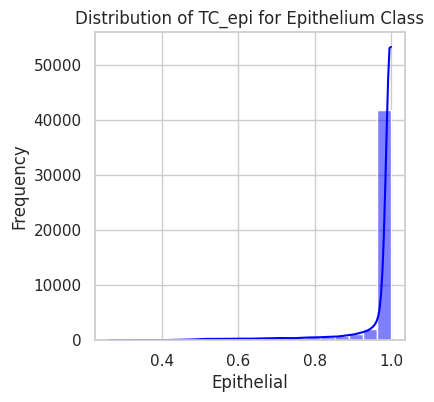

In [74]:
plt.figure(figsize=(4, 4))
sns.histplot(epi_histoROI_df['Epithelial'], bins=20, kde=True, color='blue')
plt.title('Distribution of TC_epi for Epithelium Class')
plt.xlabel('Epithelial')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [138]:
p_values = {}
categories = []
raw_p_values = []

for category in order[1:]:  # Skip the first one 'N'
    data_N = epi_histoROI_df[epi_histoROI_df['source'] == 'N']['Epithelial'].apply(lambda x: -np.log10(1 - x))
    data_category = epi_histoROI_df[epi_histoROI_df['source'] == category]['Epithelial'].apply(lambda x: -np.log10(1 - x))
    
    # Perform Mann-Whitney U test (Non-parametric test)
    stat, p_value = mannwhitneyu(data_N, data_category)
    p_values[category] = p_value
    categories.append(category)
    raw_p_values.append(p_value)

# Apply FDR correction (Benjamini-Hochberg)
rejected, fdr_corrected_pvals, _, _ = multipletests(raw_p_values, alpha=0.05, method='fdr_bh')

# Print results with FDR correction
# Print results with FDR correction
print("Mann-Whitney U test results with FDR correction:")
print("=" * 60)
for i, category in enumerate(categories):
    # 简洁的显著性标记
    significance = "***" if fdr_corrected_pvals[i] < 0.001 else "**" if fdr_corrected_pvals[i] < 0.01 else "*" if fdr_corrected_pvals[i] < 0.05 else "ns"
    
    print(f"N vs {category:4}: p-value = {raw_p_values[i]:.4f}, FDR-corrected = {fdr_corrected_pvals[i]:.4f} {significance}")

print("\nSignificance codes: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant")

Mann-Whitney U test results with FDR correction:
N vs PB  : p-value = 0.0000, FDR-corrected = 0.0000 ***
N vs UDH : p-value = 0.0000, FDR-corrected = 0.0000 ***
N vs FEA : p-value = 0.0001, FDR-corrected = 0.0001 ***
N vs ADH : p-value = 0.0000, FDR-corrected = 0.0000 ***
N vs DCIS: p-value = 0.0000, FDR-corrected = 0.0000 ***
N vs IC  : p-value = 0.0000, FDR-corrected = 0.0000 ***

Significance codes: *** p < 0.001, ** p < 0.01, * p < 0.05, ns = not significant


/tmp/ipykernel_2523612/639166897.py:7: RuntimeWarning: divide by zero encountered in log10
  data_category = epi_histoROI_df[epi_histoROI_df['source'] == category]['Epithelial'].apply(lambda x: -np.log10(1 - x))


/tmp/ipykernel_2523612/627924905.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Epithelial', y='source', data=epi_histoROI_df,


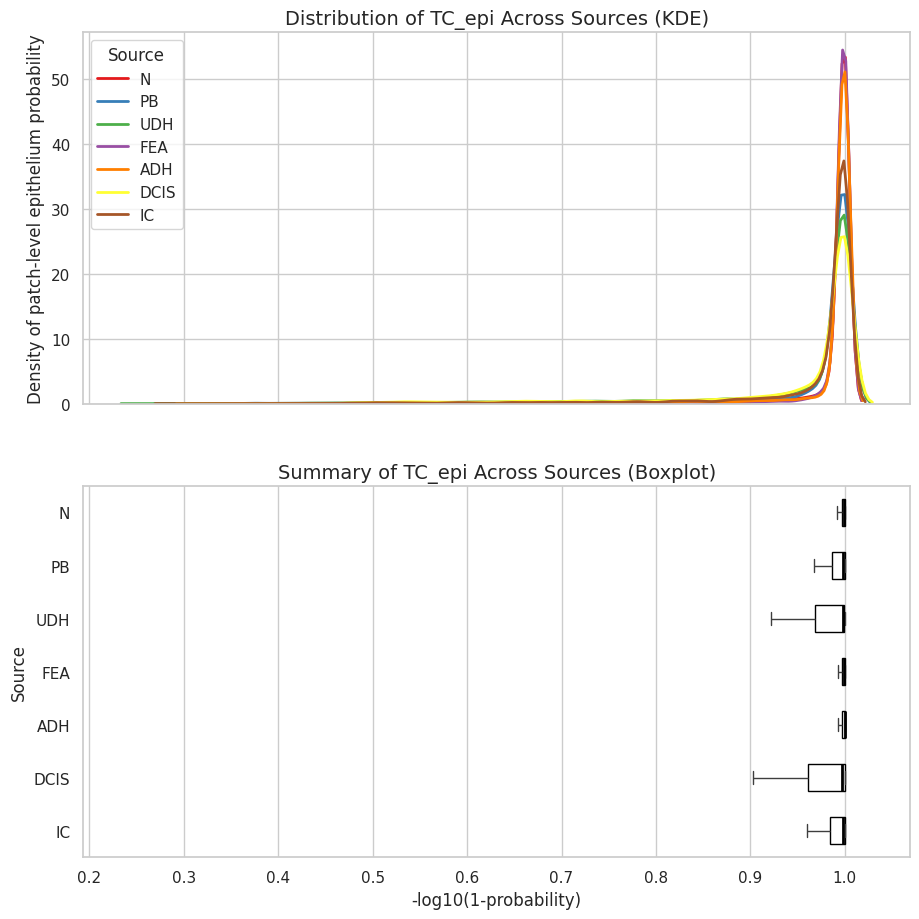

In [96]:
color_map0 = sns.color_palette('Set1', n_colors=len(source_order))
color_map = {source_order[i]: color_map0[i] for i in range(len(source_order))}

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Top subplot: KDE plot
for source in source_order:
    subset = epi_histoROI_df[epi_histoROI_df['source'] == source]['Epithelial']
    
    kde = sns.kdeplot(subset, bw_adjust=0.5, color=color_map[source], linewidth=2, label=source, ax=ax1)
    line = kde.get_lines()[-1]  # Current last line
    x_data = line.get_xdata()
    y_data = line.get_ydata()

ax1.set_ylabel('Density of patch-level epithelium probability', fontsize=12)
ax1.set_title('Distribution of TC_epi Across Sources (KDE)', fontsize=14)
ax1.legend(title='Source')

# Bottom subplot: Boxplot with color palette
sns.boxplot(x='Epithelial', y='source', data=epi_histoROI_df,
            order=source_order,
            whis=1.5, width=0.5, showcaps=True,
            boxprops={'facecolor':'none', 'edgecolor':'black'},
            medianprops={'color':'black', 'linewidth':2},
            showfliers=False, orient='h', ax=ax2,
            palette=color_map)  # Apply color map using palette

ax2.set_title('Summary of TC_epi Across Sources (Boxplot)', fontsize=14)
ax2.set_ylabel('Source', fontsize=12)
ax2.set_xlabel('-log10(1-probability)', fontsize=12)

plt.tight_layout(pad=3.0)
plt.savefig(f"{basefolder}/BRACS_patch_ids_CenterSampling_sampled8000_histoROI_epithelium_density_boxplot.pdf",
            dpi=300, bbox_inches='tight', transparent=True)
plt.show()

### Kullback–Leibler divergence (KLD)

In [ ]:
def calculate_kld_between_distributions(p_samples, q_samples, epsilon=1e-10):
    kde_p = gaussian_kde(p_samples)
    kde_q = gaussian_kde(q_samples)

    all_samples = np.concatenate([p_samples, q_samples])
    x_min, x_max = np.min(all_samples), np.max(all_samples)
    
    def integrand(x):
        p_val = kde_p(x) + epsilon
        q_val = kde_q(x) + epsilon
        return p_val * np.log(p_val / q_val)
    
    kld_value, _ = quad(integrand, x_min, x_max)
    return kld_value

In [112]:
classes = ['N', 'ADH', 'DCIS', 'FEA', 'IC', 'PB', 'UDH']
class_names = {
    'N': 'Normal', 'ADH': 'ADH', 'DCIS': 'DCIS', 'FEA': 'FEA',
    'IC': 'IC', 'PB': 'PB', 'UDH': 'UDH'
}

# NBT-Classifier
print("number of patches:")
class_data = {}
for cls in classes:
    data = epi_TC1024_df[epi_TC1024_df['source'] == cls]['TC_epi'].values
    class_data[cls] = data
    print(f"{class_names[cls]}: {len(data)}")

kld_results = {}
comparison_classes = [cls for cls in classes if cls != 'N']

for cls in comparison_classes:
    kld_value = calculate_kld_between_distributions(class_data['N'], class_data[cls])
    kld_results[f"N_vs_{cls}"] = kld_value


# 可选：将结果保存到DataFrame便于后续分析
kld_TC1024 = pd.DataFrame({
    'Comparison': [f"N vs {class_names[cls]}" for cls in comparison_classes],
    'KLD': [kld_results[f"N_vs_{cls}"] for cls in comparison_classes]
})
kld_TC1024

number of patches:
Normal: 7910
ADH: 7893
DCIS: 7604
FEA: 7681
IC: 7807
PB: 7297
UDH: 7644


,Comparison,KLD
0,N vs ADH,0.231196
1,N vs DCIS,0.375504
2,N vs FEA,0.261753
3,N vs IC,0.169667
4,N vs PB,0.169143
5,N vs UDH,0.070730


In [114]:
# histoROI
print("number of patches:")
class_data = {}
for cls in classes:
    data = epi_histoROI_df[epi_histoROI_df['source'] == cls]['Epithelial'].values
    class_data[cls] = data
    print(f"{class_names[cls]}: {len(data)}")

kld_results = {}
comparison_classes = [cls for cls in classes if cls != 'N']

for cls in comparison_classes:
    kld_value = calculate_kld_between_distributions(class_data['N'], class_data[cls])
    kld_results[f"N_vs_{cls}"] = kld_value


kld_histoROI = pd.DataFrame({
    'Comparison': [f"N vs {class_names[cls]}" for cls in comparison_classes],
    'KLD': [kld_results[f"N_vs_{cls}"] for cls in comparison_classes]
})
kld_histoROI

number of patches:
Normal: 7735
ADH: 7366
DCIS: 6172
FEA: 7454
IC: 7081
PB: 6777
UDH: 7000


,Comparison,KLD
0,N vs ADH,0.010730
1,N vs DCIS,0.072391
2,N vs FEA,0.012331
3,N vs IC,-0.015144
4,N vs PB,0.033443
5,N vs UDH,0.049540


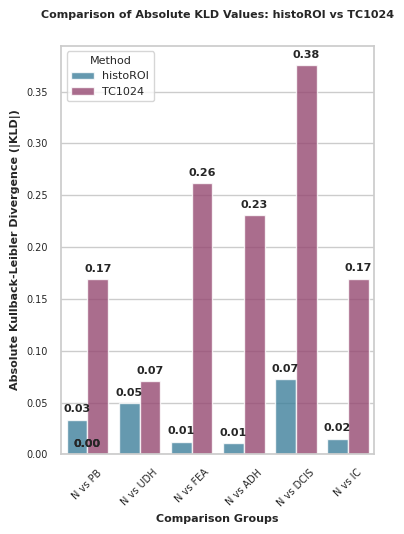

In [132]:
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.dpi'] = 100


kld_TC1024['KLD_abs'] = kld_TC1024['KLD'].abs()
kld_histoROI['KLD_abs'] = kld_histoROI['KLD'].abs()


specified_order = ['N vs PB', 'N vs UDH', 'N vs FEA', 'N vs ADH', 'N vs DCIS', 'N vs IC']


kld_TC1024_sorted = kld_TC1024.set_index('Comparison').loc[specified_order].reset_index()
kld_histoROI_sorted = kld_histoROI.set_index('Comparison').loc[specified_order].reset_index()

kld_combined = pd.concat([
    kld_histoROI_sorted.assign(Method='histoROI'),
    kld_TC1024_sorted.assign(Method='TC1024')
])


plt.figure(figsize=(4, 5.5))
ax = sns.barplot(data=kld_combined, x='Comparison', y='KLD_abs', hue='Method', 
                 palette=['#2E86AB', '#A23B72'], alpha=0.8)


for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.005,
            f'{height:.2f}', ha='center', va='bottom', fontsize=8, fontweight='bold')


ax.set_xlabel('Comparison Groups', fontsize=8, fontweight='bold')
ax.set_ylabel('Absolute Kullback-Leibler Divergence (|KLD|)', fontsize=8, fontweight='bold')
ax.set_title('Comparison of Absolute KLD Values: histoROI vs TC1024', 
             fontsize=8, fontweight='bold', pad=20)
ax.tick_params(axis='x', rotation=45, labelsize=7)  # Adjusting x-axis tick font size
ax.tick_params(axis='y', labelsize=7)
ax.legend(title='Method', title_fontsize=8, fontsize=8)


plt.tight_layout()
plt.savefig(f"{basefolder}/BRACS_patch_ids_CenterSampling_sampled8000_Both_epithelium_KLD_barplot.pdf",
            dpi=300, bbox_inches='tight', transparent=True)
plt.show()